# Competition 2025 Task 2: Phase offset prediction

Wellcome to this years 2025 MLOC competition!
If you have any questions, don't hesitate to ask a question in the forum or send an email to sisi.miao@kit.edu or rodrigo.fischer@kit.edu.

Have fun!

Enter your team name here:

In [1]:
# Before you start, please enter your team name!
team_name = 'ZSC'

The main code starts here...

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [3]:
# In case you want to use PyTorch to build your clasifier
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


In [4]:
# Checks if the data you upload has the correct type/form
def check_predictions(test_data, predictions):
    """Checks if predictions has the right length and type."""
    if isinstance(predictions,np.ndarray):
        print('type ok.')
    else:
        raise Exception('wrong type, predictions should be of type np.ndarray')

    if predictions.ndim != 1:
        raise Exception('wrong dimension, predictions must have dim 1')
    else:
        print('dim ok.')

    if len(test_data) != len(predictions):
        raise Exception('wrong length, "X_test" and "predictions" must have the same length.')
    else:
        print('length ok.')

    if predictions.dtype != 'float32':
        raise Exception('Wrong data type! Must be np.float32!')
    else:
        print('dtype ok.')


## Task 2: Find the correct phase offset
You receive the samples of a BPSK communications signal and your task is to devise an ML solution to determine the unknown phase offset of the signal. At your disposal you have a dataset with $8\cdot10^4$ example sequences of 128 complex samples each (inphase and quadrature components), accompanied by an array containing the true phase offset used to generate each sequence and an array containing the sequence SNR. 

To perform cross-validation of your strategy, we also make available a statistically identical and smaller dataset with the corresponding phase offset and SNR labels. Use the SNR information however you like.  **Note that the test dataset does _not_ contain the SNR values. You can only use the SNR values for training and validation if you like.** Your model will be evaluated on a test dataset, that will also be made available, but whose labels won't be revealed. Both the regression and classification approaches can be used, however the predicted values must be given as floating-point values representing the phase offset (in radians), and the performance will be evaluated using the mean squared error (MSE) to the true phase offset. Aditionally, feel free to try classical DSP approaches.

As a side result, show a plot containing the MSE on the evaluation dataset for each SNR separatelly. 

The phase offset is a random variable sampled independently for each sequence from $U(-\frac{\pi}{3}, \frac{\pi}{3})$, and it remains constant for all the 128 samples of each sequence. Aditional impairments on the sequence include AWGN noise and a random unknown sampling time for each sequence.

The datasets are stored in pickle files. The array `X_train` contains the sequences (the examples). The corresponding labels (the phase offset) are given by `Y_train` and the corresponding SNR is given in `SNR_train`. The label in `Y_train` corresponds to a phase offset in $[-\frac{\pi}{3}, \frac{\pi}{3}]$.

In [5]:
# Check if data sets are available
from os.path import exists
file_prefix='./'
if exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task2_dataset_train.pkl'):
    file_prefix ='/home/jovyan/work/__shared/'

if not exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task2_dataset_train.pkl') and not exists('MLOC_Competition_2025_task2_dataset_train.pkl'):
     print('Training data must be either in __shared folder or in current folder')

if not exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task2_dataset_valid.pkl') and not exists('MLOC_Competition_2025_task2_dataset_valid.pkl'):
    print('Training data must be either in __shared folder or in current folder')

if not exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task2_test_data.pkl') and not exists('MLOC_Competition_2025_task2_test_data.pkl'):
    print('Training data must be either in __shared folder or in current folder')

In [6]:
# Load training dataset
with open(file_prefix+'MLOC_Competition_2025_task2_dataset_train.pkl', "rb") as f:
    X_train_task_2 = pickle.load(f)
    Y_train_task_2 = pickle.load(f)
    SNR_train_task_2 = pickle.load(f)
    SNRs_task_2 = pickle.load(f)
    
# Load validation dataset
with open(file_prefix+'MLOC_Competition_2025_task2_dataset_valid.pkl', "rb") as f:
    X_valid_task_2 = pickle.load(f)
    Y_valid_task_2 = pickle.load(f)
    SNR_valid_task_2 = pickle.load(f) 
    
# Load test data
with open(file_prefix+'MLOC_Competition_2025_task2_test_data.pkl', "rb") as f:
    X_test_task_2 = pickle.load(f)

In [7]:
print('SNR values: ', SNRs_task_2)

SNR values:  [ 0  2  4  6  8 10 12 14 16 18]


Here you can visualize the sequences:

(hint: what other type of plot you can use to better visualize the phase offset?)

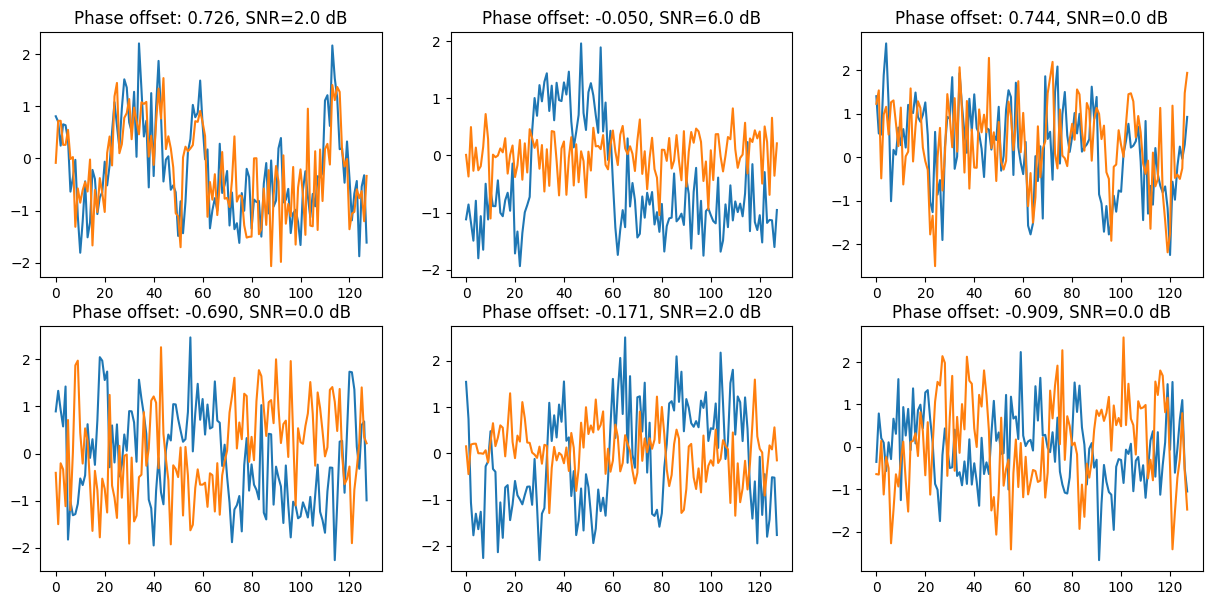

In [8]:
starti = np.random.randint(0,X_train_task_2.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task_2[k+starti,:]))
    plt.plot(np.imag(X_train_task_2[k+starti,:]))
    plt.title(f'Phase offset: {Y_train_task_2[k+starti]:.3f}, SNR={SNR_train_task_2[k+starti]} dB')

Epoch 010 — train loss: 0.036513, val loss: 0.027539
Epoch 020 — train loss: 0.019363, val loss: 0.010872
Epoch 030 — train loss: 0.016356, val loss: 0.008277
Epoch 040 — train loss: 0.015242, val loss: 0.009440
Epoch 050 — train loss: 0.013156, val loss: 0.009042
Epoch 060 — train loss: 0.012587, val loss: 0.007782
Epoch 070 — train loss: 0.011973, val loss: 0.007197
Epoch 080 — train loss: 0.011288, val loss: 0.006919
Epoch 090 — train loss: 0.011066, val loss: 0.007783
Epoch 100 — train loss: 0.010999, val loss: 0.007494


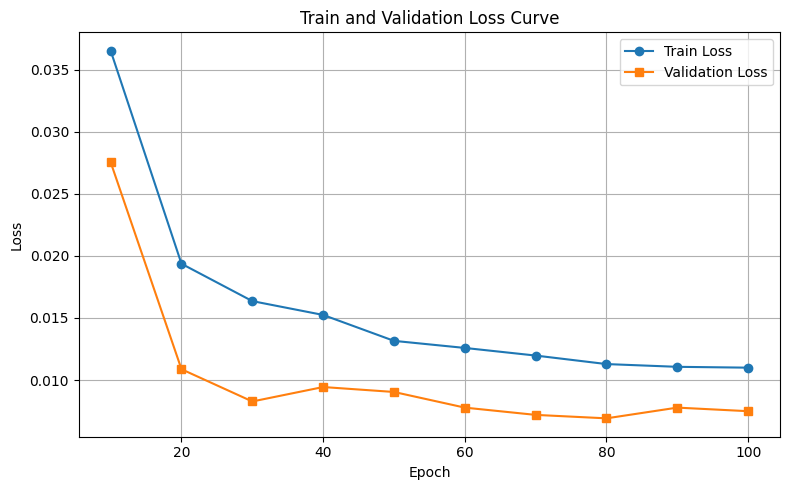

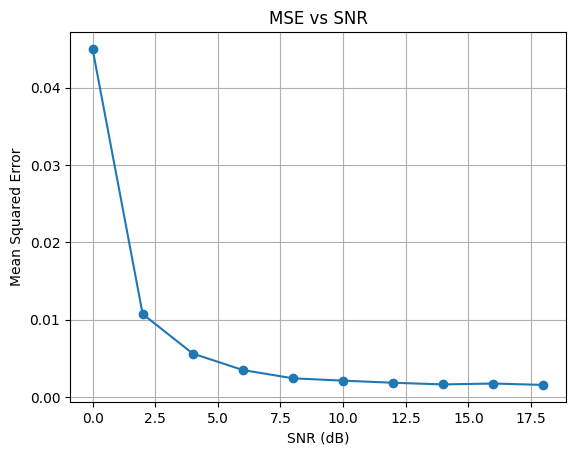

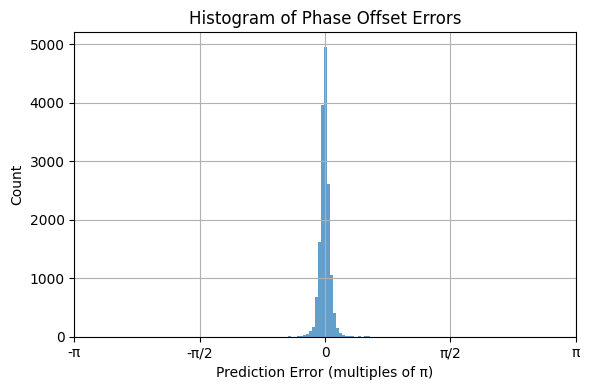

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# ─── 1) PREPARE DATA FROM OFFICIAL TRAIN & VALID SETS ───────────────────────────

def make_iq_tensor(X_complex):
    """Convert (N,128) complex array → (N,1,2,128) real‐imag tensor."""
    arr = np.stack([X_complex.real, X_complex.imag], axis=1)  # → (N,2,128)
    return arr[:, None, :, :]                                # → (N,1,2,128)

# Train set
X_train_np = make_iq_tensor(np.array(X_train_task_2))
Y_train_np = np.array(Y_train_task_2, dtype=np.float32)
SNR_train  = np.array(SNR_train_task_2)

# Valid set
X_test_np  = make_iq_tensor(np.array(X_valid_task_2))
Y_test_np  = np.array(Y_valid_task_2, dtype=np.float32)
SNR_test   = np.array(SNR_valid_task_2)

# ─── 2) CONVERT TO TORCH TENSORS & DATALOADERS ─────────────────────────────────

X_train_t = torch.from_numpy(X_train_np).float()
Y_train_t = torch.from_numpy(Y_train_np).float()
X_test_t  = torch.from_numpy(X_test_np).float()
Y_test_t  = torch.from_numpy(Y_test_np).float()

batch_size = 32
train_loader = DataLoader(
    TensorDataset(X_train_t, Y_train_t),
    batch_size=batch_size, shuffle=True,  pin_memory=True
)
test_loader = DataLoader(
    TensorDataset(X_test_t, Y_test_t),
    batch_size=batch_size, shuffle=False, pin_memory=True
)

# ─── 3) DEFINE THE CNN–LSTM REGRESSOR ────────────────────────────────────────────

class CNN_LSTM_Regressor(nn.Module):
    def __init__(self, dr=0.5, lstm_hidden=50, fc_hidden=256):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 50, (1,7), padding=(0,3))
        self.conv2 = nn.Conv2d(50,50,(1,7), padding=(0,3))
        self.conv3 = nn.Conv2d(50,50,(1,7), padding=(0,3))
        self.dropout = nn.Dropout(dr)
        self.lstm = nn.LSTM(input_size=100*128, hidden_size=lstm_hidden, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, 1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x)); x1 = self.dropout(x1)
        x2 = F.relu(self.conv2(x1)); x2 = self.dropout(x2)
        x3 = F.relu(self.conv3(x2)); x3 = self.dropout(x3)
        cat = torch.cat([x1, x3], dim=1)
        B,C,T,W = cat.shape
        cat = cat.permute(0,2,1,3).reshape(B, T, C*W)
        out,_ = self.lstm(cat)
        last = out[:, -1, :]
        y = F.relu(self.fc1(last)); y = self.dropout(y)
        return self.fc2(y).squeeze(-1)

# ─── 4) TRAIN & LOG LOSS ─────────────────────────────────────────────────────────

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = CNN_LSTM_Regressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses = []
val_losses   = []
epoch_list   = []

for epoch in range(1, 101):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    if epoch % 10 == 0:
        avg_train = running_loss / len(train_loader.dataset)
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                running_val += criterion(model(xb), yb).item() * xb.size(0)
        avg_val = running_val / len(test_loader.dataset)

        train_losses.append(avg_train)
        val_losses.append(avg_val)
        epoch_list.append(epoch)

        print(f"Epoch {epoch:03d} — train loss: {avg_train:.6f}, val loss: {avg_val:.6f}")

# ─── 5) PLOT TRAIN/VALIDATION LOSS ───────────────────────────────────────────────

plt.figure(figsize=(8,5))
plt.plot(epoch_list, train_losses, 'o-', label='Train Loss')
plt.plot(epoch_list, val_losses,   's-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── 6) EVALUATE & PLOT MSE VS. SNR ─────────────────────────────────────────────

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        preds = model(xb).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

snr_levels = np.unique(SNR_test)
mse_per_snr = [np.mean((all_preds[SNR_test==s]-all_labels[SNR_test==s])**2)
               for s in snr_levels]

plt.figure()
plt.plot(snr_levels, mse_per_snr, 'o-')
plt.title("MSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()

# ─── 7) PHASE‐ERROR HISTOGRAM IN π‐UNITS ────────────────────────────────────────

phase_err = all_preds - all_labels

plt.figure(figsize=(6,4))
plt.hist(phase_err, bins=100, alpha=0.7)
xticks       = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
xtick_labels = ['-π', '-π/2', '0', 'π/2', 'π']
plt.xticks(xticks, xtick_labels)
plt.xlabel('Prediction Error (multiples of π)')
plt.ylabel('Count')
plt.title('Histogram of Phase Offset Errors')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
### Your code goes here :)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        preds = model(xb).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

snr_levels = np.unique(SNR_test)
mse_per_snr = [
    np.mean((all_preds[SNR_test == s] - all_labels[SNR_test == s])**2)
    for s in snr_levels
]
# Provide a list with name mse_separate that has the same length as SNRs_task_2, 
# and that for each entry you have the classification error for the corresponding SNR on the validation set
# here we just preload the list with dummy data
mse_separate = range(len(SNRs_task_2))
mse_separate = mse_per_snr

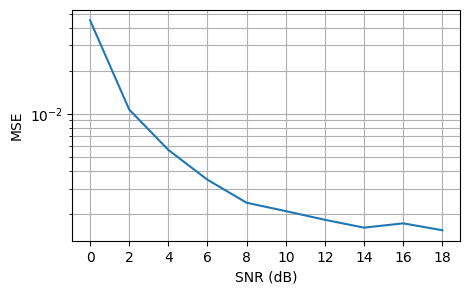

In [15]:
# Plot Results
plt.figure(figsize=(5,3))
plt.plot(SNRs_task_2, mse_separate)
plt.yscale('log')
plt.axis('tight')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.xticks(SNRs_task_2)
plt.grid(which='both')
plt.savefig('Competition_Task2_MSE_Plot.pdf', bbox_inches='tight')

In [16]:
### Your code goes here :)
import numpy as np
import torch
from torch.utils.data import DataLoader

# 1) Build the (N,1,2,128) IQ tensor from the complex test samples
def make_iq_tensor(X_complex):
    arr = np.stack([X_complex.real, X_complex.imag], axis=1)  # (N,2,128)
    return arr[:, None, :, :]                                # (N,1,2,128)

X_submit_np = make_iq_tensor(np.array(X_test_task_2))
X_submit_t  = torch.from_numpy(X_submit_np).float()       # CPU tensor

# 2) Feed it through a DataLoader
submit_loader = DataLoader(
    X_submit_t, 
    batch_size=32, 
    shuffle=False, 
    pin_memory=True
)

# 3) Model inference
model.eval()
all_preds = []
with torch.no_grad():
    for xb in submit_loader:
        xb = xb.to(device, non_blocking=True)
        preds = model(xb).cpu().numpy()   # shape (batch,)
        all_preds.append(preds)

# 4) Concatenate and cast to float32
predictions_task_2 = np.concatenate(all_preds, axis=0).astype(np.float32)

### Here, get the predictions from your model that will be submitted 
#predictions_task_2 = -np.pi / 3 + 2 * np.pi / 3 * np.random.rand(X_test_task_2.shape[0]).astype(np.float32)

### Don't touch this part
check_predictions(X_test_task_2, predictions_task_2)

with open('Task_2_%s.pkl' % (team_name),'wb') as f:
    pickle.dump(predictions_task_2,f)

type ok.
dim ok.
length ok.
dtype ok.
